In [35]:
!pip install lifelines
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dateutil import relativedelta
from sklearn.metrics import auc
import math
from google.colab import files
from copy import deepcopy
from collections import defaultdict

In [36]:
from math import nan
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")


# modified dataframes with high collinearity removed
df_train_mod = df_train[['BorrState',"ThirdPartyDollars","GrossApproval","TermInMonths", "Term Multiple", "Same State", "In CA", "Is ThirdParty", "Missing Interest", "Refinance",  "Private Sector", "Premier", "CORPORATION", "INDIVIDUAL", "MISSING", "PARTNERSHIP", "Unemployment YR", "Avg Home Price", "GDP Delta YR", "Log S&P Open", "BorrState Unemployment","ProjectState Unemployment", "BorrState Income", "ProjState Income","Missing Borr Income", "BorrState GDP", "ProjState GDP", "Missing Borr GDP", "Missing Proj GDP","BorrState Vacancy","ProjectState Vacancy"]]
df_test_mod = df_test[['BorrState',"ThirdPartyDollars","GrossApproval","TermInMonths", "Term Multiple", "Same State", "In CA", "Is ThirdParty", "Missing Interest", "Refinance",  "Private Sector", "Premier", "CORPORATION", "INDIVIDUAL", "MISSING", "PARTNERSHIP", "Unemployment YR", "Avg Home Price", "GDP Delta YR", "Log S&P Open", "BorrState Unemployment","ProjectState Unemployment", "BorrState Income", "ProjState Income","Missing Borr Income", "BorrState GDP", "ProjState GDP", "Missing Borr GDP", "Missing Proj GDP","BorrState Vacancy","ProjectState Vacancy"]]
df_train_mod['Event'] = df_train['LoanStatus'].apply(lambda x: 1 if x == "CHGOFF" else 0)
df_test_mod['Event'] = df_test['LoanStatus'].apply(lambda x: 1 if x == "CHGOFF" else 0)

df_train_mod = df_train_mod.drop(columns = ['BorrState'])
df_test_mod = df_test_mod.drop(columns = ['BorrState'])

df_test_mod = df_test_mod.reset_index()
train_duration = []
chgoff_train = np.array(df_train['ChargeOffDate'])
term_train = np.array(df_train['TermInMonths'])
app_train = np.array(df_train['ApprovalDate'])

for i in range(len(chgoff_train)):
  if pd.isna(chgoff_train[i]): train_duration.append(term_train[i])
  else:
    delt = relativedelta.relativedelta(datetime.strptime(chgoff_train[i], "%Y-%m-%d"), datetime.strptime(app_train[i], "%Y-%m-%d"))
    train_duration.append( delt.years*12 + delt.months)
df_train_mod['Duration'] = pd.Series(train_duration)

<ipython-input-36-9afa4c9ab6bd>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("df_train.csv")
<ipython-input-36-9afa4c9ab6bd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_mod['Event'] = df_train['LoanStatus'].apply(lambda x: 1 if x == "CHGOFF" else 0)
<ipython-input-36-9afa4c9ab6bd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_mod['Event'] = df_test['LoanStatus'].apply(lambda x: 1 if x == "CHGOFF" el

In [37]:
cox = CoxPHFitter(penalizer=0.001)
cox.fit(df_train_mod, duration_col='Duration', event_col='Event')
survival = cox.predict_survival_function(df_test_mod)
survival.index = survival.index.astype(int)
default_prob = survival * -1 + 1
thres = np.linspace(0.000, 1.000, num=1001)

test_term = np.array(df_test_mod['TermInMonths'])
prob_at_term = []
for i, j in enumerate(test_term):
  prob_at_term.append(default_prob.iloc[default_prob.index.get_loc(j,method='nearest'), i])

Streaming output truncated to the last 5000 lines.
<ipython-input-37-d0078d5c50fe>:11: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  prob_at_term.append(default_prob.iloc[default_prob.index.get_loc(j,method='nearest'), i])
<ipython-input-37-d0078d5c50fe>:11: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  prob_at_term.append(default_prob.iloc[default_prob.index.get_loc(j,method='nearest'), i])
<ipython-input-37-d0078d5c50fe>:11: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  prob_at_term.append(default_prob.iloc[default_prob.index.get_loc(j,method='nearest'), i])
<ipython-input-37-d0078d5c50fe>:11: FutureWarning: Passing method to Int64Index.get_loc is deprecated and 

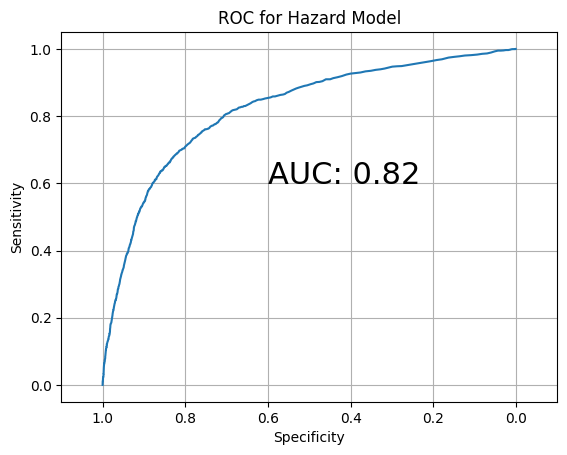

In [38]:
TP, TN = [], []
prob_at_term = np.array(prob_at_term)
for i in thres:
  typ = (prob_at_term > i).astype(int)
  # get true positive and negative for ROC
  tp = float(np.sum(np.logical_and(typ == 1, np.array(df_test_mod['Event']) == 1)))/np.sum(np.array(df_test_mod['Event']) == 1)
  tn = float(np.sum(np.logical_and(typ == 0, np.array(df_test_mod['Event']) == 0)))/np.sum(np.array(df_test_mod['Event']) == 0)
  TP.append(tp)
  TN.append(tn)
plt.plot(TN,TP)
plt.xlim(1.1, -0.1)
plt.title("ROC for Hazard Model")
plt.xlabel("Specificity")
plt.ylabel("Sensitivity")
plt.text(0.6, 0.6, 'AUC: ' + str(round(auc(TN,TP),3)), fontsize = 22)
plt.grid()

### **The Following Code Blocks Create Time-Varying Dataframes**
**Note:** Only first 10000 samples of the training set was used

In [39]:
df_train_TV = df_train_mod
df_train_TV['ID'] = df_train_TV.index
df_train_TV['ApprovalYear'] = df_train['ApprovalFiscalYear']
df_train_TV['BorrState'] = df_train['BorrState']
df_train_TV['ProjectState'] = df_train['ProjectState']

df_train_5000 = pd.DataFrame(columns=df_train_TV.columns)
for i in range(10000):
  df_train_5000 = df_train_5000.append(df_train_TV[df_train_TV['ID'] == i+1])

df_test_5000 = df_train_5000.sample(frac=0.2, random_state=1)
df_train_5000 = df_train_5000.drop(df_test_5000.index)

df_train_5000['start'] = pd.Series([0]*len(df_train_5000))
df_train_5000['end'] = pd.Series([0]*len(df_train_5000))

df_train_Expanded = pd.DataFrame(columns=df_train_5000.columns)

for i in np.array(df_train_5000['ID']):
  to_append = deepcopy([df_train_5000[df_train_5000['ID'] == i]]) * (math.ceil(float(df_train_5000[df_train_5000['ID'] == i]['Duration'])/12))
  temp_append = pd.DataFrame(columns=df_train_5000.columns)
  temp_append = temp_append.append(to_append)
  temp_append = temp_append.reset_index()
  for j in range(len(temp_append)):
    temp_append.iloc[j, temp_append.columns.get_loc('start')] = int(j)
    temp_append.iloc[j, temp_append.columns.get_loc('end')] = int(j+1)
  if temp_append.iloc[0]['Event'] != 0:
    temp_event = np.array(temp_append['Event'])
    temp_append['Event'] = pd.Series([0]*(len(temp_event)-1) + [1])
  df_train_Expanded = df_train_Expanded.append(temp_append)


Streaming output truncated to the last 5000 lines.
<ipython-input-39-221ab5e7cc1c>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_append = temp_append.append(to_append)
<ipython-input-39-221ab5e7cc1c>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_Expanded = df_train_Expanded.append(temp_append)
<ipython-input-39-221ab5e7cc1c>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_append = temp_append.append(to_append)
<ipython-input-39-221ab5e7cc1c>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_Expanded = df_train_Expanded.append(temp_append)
<ipython-input-39-221ab5e7cc1c>:22: FutureWarning: The frame.

In [40]:
df_train_Expanded = df_train_Expanded.reset_index()
df_cop = deepcopy(df_train_Expanded)

In [41]:
df_cop = deepcopy(df_train_Expanded)

In [42]:
df_unemployment = pd.read_csv('us-national-unemployment-rate.csv', skiprows = 15)
df_unemployment['date'] = df_unemployment['date'].apply(lambda x: int(x[:4]))
yr, unemp = np.array(df_unemployment['date']), np.array(df_unemployment[' value'])
unemp_dict = defaultdict(float)
for i,j in enumerate(yr):
  unemp_dict[j] = unemp[i]
# add unemployment rate as feature (year)
df_cop['Unemployment YR'] = df_cop.apply(lambda x: unemp_dict[int(x['ApprovalYear']+x['start'])], axis=1)

In [43]:
df_state_unemp = pd.read_excel('Unemployment_State.xlsx')
df_state_unemp['DATE'] = df_state_unemp['DATE'].apply(lambda x: int(str(x)[:4]))
df_state_unemp = df_state_unemp.set_index('DATE')
yr,st_borr, st_proj = [int(i) for i in np.add(list(df_cop['ApprovalYear']),list(df_cop['start']))], list(df_cop['BorrState']), list(df_cop['ProjectState'])
borr_st_unemp, proj_st_unemp = [], []
for i,j in enumerate(yr):
  if j <= 2022:
    borr_st_unemp.append(df_state_unemp.loc[j,st_borr[i]])
    proj_st_unemp.append(df_state_unemp.loc[j,st_proj[i]])
  else:
    borr_st_unemp.append(0)
    proj_st_unemp.append(0)

df_cop['BorrState Unemployment'] = pd.Series(borr_st_unemp)
df_cop['ProjectState Unemployment'] = pd.Series(proj_st_unemp)

In [44]:
# add personal income per capita in each state during the year of loan approval for borrower and project, as well as add missing indicators
df_income = pd.read_excel('Personal Income Per Capita by State.xlsx')
df_income = df_income.set_index('State')
yr,st_borr, st_proj = [int(i) for i in np.add(list(df_cop['ApprovalYear']),list(df_cop['start']))], list(df_cop['BorrState']), list(df_cop['ProjectState'])
borr_st_inc, proj_st_inc = [], []
for i,j in enumerate(yr):
  if j <= 2016:
    borr_st_inc.append(df_income.loc[st_borr[i], j])
    proj_st_inc.append(df_income.loc[st_proj[i], j])
  else:
    borr_st_inc.append(0)
    proj_st_inc.append(0)

df_cop['BorrState Income'] = pd.Series(borr_st_inc)
df_cop['ProjState Income'] = pd.Series(proj_st_inc)

df_cop['Missing Borr Income'] = df_cop['BorrState Income'].apply(lambda x: 0 if not pd.isnull(x) else 1)
df_cop['Missing Proj Income'] = df_cop['ProjState Income'].apply(lambda x: 0 if not pd.isnull(x) else 1)
df_cop['BorrState Income'] = df_cop['BorrState Income'].fillna(0)
df_cop['ProjState Income'] = df_cop['ProjState Income'].fillna(0)

In [45]:
df_home = pd.read_csv('MSPUS.csv')
df_home['DATE'] = df_home['DATE'].apply(lambda x: int(x[:4]))
yr, price = np.array(df_home['DATE']), np.array(df_home['MSPUS'])
home_dict = defaultdict(list)
for i,j in enumerate(yr):
  home_dict[j].append(price[i])
# add year-before average home price as feature (year)
df_cop['Avg Home Price'] = df_cop.apply(lambda x: np.mean(home_dict[int(x['ApprovalYear']+x['start'])]), axis = 1)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [46]:
# process USA gdp growth rate annual change
df_gdp = pd.read_csv('united-states-gdp-growth-rate.csv', skiprows = 16)
df_gdp['date'] = df_gdp['date'].apply(lambda x: int(x[:4]))
yr, gdp = np.array(df_gdp['date']), np.array(df_gdp[' Annual Change'])
gdp_dict = defaultdict(float)
for i,j in enumerate(yr):
  gdp_dict[j] = gdp[i]
# add year-before gdp annual change as feature (year)
df_cop['GDP Delta YR'] = df_cop.apply(lambda x: gdp_dict[int(x['ApprovalYear']+x['start'])], axis = 1)

In [47]:
# add housing vacancy rate by state during the year
df_state_vac = pd.read_excel('Vacancy Rate.xlsx')
df_state_vac['Date'] = df_state_vac['Date'].apply(lambda x: int(str(x)[:4]))
df_state_vac = df_state_vac.set_index('Date')
yr,st_borr, st_proj = [int(i) for i in np.add(list(df_cop['ApprovalYear']),list(df_cop['start']))], list(df_cop['BorrState']), list(df_cop['ProjectState'])
borr_st_vac, proj_st_vac = [], []
for i,j in enumerate(yr):
  if j <= 2022:
    borr_st_vac.append(df_state_vac.loc[j,st_borr[i]])
    proj_st_vac.append(df_state_vac.loc[j,st_proj[i]])
  else:
    borr_st_vac.append(0)
    proj_st_vac.append(0)
df_cop['BorrState Vacancy'] = pd.Series(borr_st_vac)
df_cop['ProjectState Vacancy'] = pd.Series(proj_st_vac)

In [48]:
df_cop = df_cop.drop(columns = ['level_0','BorrState','ProjectState','index'])
print(df_cop.columns)

Index(['ThirdPartyDollars', 'GrossApproval', 'TermInMonths', 'Term Multiple',
       'Same State', 'In CA', 'Is ThirdParty', 'Missing Interest', 'Refinance',
       'Private Sector', 'Premier', 'CORPORATION', 'INDIVIDUAL', 'MISSING',
       'PARTNERSHIP', 'Unemployment YR', 'Avg Home Price', 'GDP Delta YR',
       'Log S&P Open', 'BorrState Unemployment', 'ProjectState Unemployment',
       'BorrState Income', 'ProjState Income', 'Missing Borr Income',
       'BorrState GDP', 'ProjState GDP', 'Missing Borr GDP',
       'Missing Proj GDP', 'BorrState Vacancy', 'ProjectState Vacancy',
       'Event', 'Duration', 'ID', 'ApprovalYear', 'start', 'end',
       'Missing Proj Income'],
      dtype='object')


In [49]:
df_cop['Avg Home Price'] = df_cop['Avg Home Price'].fillna(0)
df_cop = df_cop.drop(columns = ['ApprovalYear'])

In [50]:
df_test_5000['start'] = pd.Series([0]*len(df_test_5000))
df_test_5000['end'] = pd.Series([0]*len(df_test_5000))

df_test_Expanded = pd.DataFrame(columns=df_test_5000.columns)

for i in np.array(df_test_5000['ID']):
  to_append = deepcopy([df_test_5000[df_test_5000['ID'] == i]]) * (math.ceil(float(df_test_5000[df_test_5000['ID'] == i]['Duration'])/12))
  temp_append = pd.DataFrame(columns=df_test_5000.columns)
  temp_append = temp_append.append(to_append)
  temp_append = temp_append.reset_index()
  for j in range(len(temp_append)):
    temp_append.iloc[j, temp_append.columns.get_loc('start')] = int(j)
    temp_append.iloc[j, temp_append.columns.get_loc('end')] = int(j+1)
  if temp_append.iloc[0]['Event'] != 0:
    temp_event = np.array(temp_append['Event'])
    temp_append['Event'] = pd.Series([0]*(len(temp_event)-1) + [1])
  df_test_Expanded = df_test_Expanded.append(temp_append)


df_unemployment = pd.read_csv('us-national-unemployment-rate.csv', skiprows = 15)
df_unemployment['date'] = df_unemployment['date'].apply(lambda x: int(x[:4]))
yr, unemp = np.array(df_unemployment['date']), np.array(df_unemployment[' value'])
unemp_dict = defaultdict(float)
for i,j in enumerate(yr):
  unemp_dict[j] = unemp[i]
# add unemployment rate as feature (year)
df_test_Expanded['Unemployment YR'] = df_test_Expanded.apply(lambda x: unemp_dict[int(x['ApprovalYear']+x['start'])], axis=1)

df_state_unemp = pd.read_excel('Unemployment_State.xlsx')
df_state_unemp['DATE'] = df_state_unemp['DATE'].apply(lambda x: int(str(x)[:4]))
df_state_unemp = df_state_unemp.set_index('DATE')
yr,st_borr, st_proj = [int(i) for i in np.add(list(df_test_Expanded['ApprovalYear']),list(df_test_Expanded['start']))], list(df_test_Expanded['BorrState']), list(df_test_Expanded['ProjectState'])
borr_st_unemp, proj_st_unemp = [], []
for i,j in enumerate(yr):
  if j <= 2022:
    borr_st_unemp.append(df_state_unemp.loc[j,st_borr[i]])
    proj_st_unemp.append(df_state_unemp.loc[j,st_proj[i]])
  else:
    borr_st_unemp.append(0)
    proj_st_unemp.append(0)

df_test_Expanded['BorrState Unemployment'] = pd.Series(borr_st_unemp)
df_test_Expanded['ProjectState Unemployment'] = pd.Series(proj_st_unemp)

# add personal income per capita in each state during the year of loan approval for borrower and project, as well as add missing indicators
df_income = pd.read_excel('Personal Income Per Capita by State.xlsx')
df_income = df_income.set_index('State')
yr,st_borr, st_proj = [int(i) for i in np.add(list(df_test_Expanded['ApprovalYear']),list(df_test_Expanded['start']))], list(df_test_Expanded['BorrState']), list(df_test_Expanded['ProjectState'])
borr_st_inc, proj_st_inc = [], []
for i,j in enumerate(yr):
  if j <= 2016:
    borr_st_inc.append(df_income.loc[st_borr[i], j])
    proj_st_inc.append(df_income.loc[st_proj[i], j])
  else:
    borr_st_inc.append(0)
    proj_st_inc.append(0)

df_test_Expanded['BorrState Income'] = pd.Series(borr_st_inc)
df_test_Expanded['ProjState Income'] = pd.Series(proj_st_inc)

df_test_Expanded['Missing Borr Income'] = df_test_Expanded['BorrState Income'].apply(lambda x: 0 if not pd.isnull(x) else 1)
df_test_Expanded['Missing Proj Income'] = df_test_Expanded['ProjState Income'].apply(lambda x: 0 if not pd.isnull(x) else 1)
df_test_Expanded['BorrState Income'] = df_test_Expanded['BorrState Income'].fillna(0)
df_test_Expanded['ProjState Income'] = df_test_Expanded['ProjState Income'].fillna(0)


df_home = pd.read_csv('MSPUS.csv')
df_home['DATE'] = df_home['DATE'].apply(lambda x: int(x[:4]))
yr, price = np.array(df_home['DATE']), np.array(df_home['MSPUS'])
home_dict = defaultdict(list)
for i,j in enumerate(yr):
  home_dict[j].append(price[i])
# add year-before average home price as feature (year)
df_test_Expanded['Avg Home Price'] = df_test_Expanded.apply(lambda x: np.mean(home_dict[int(x['ApprovalYear']+x['start'])]), axis = 1)

# process USA gdp growth rate annual change
df_gdp = pd.read_csv('united-states-gdp-growth-rate.csv', skiprows = 16)
df_gdp['date'] = df_gdp['date'].apply(lambda x: int(x[:4]))
yr, gdp = np.array(df_gdp['date']), np.array(df_gdp[' Annual Change'])
gdp_dict = defaultdict(float)
for i,j in enumerate(yr):
  gdp_dict[j] = gdp[i]
# add year-before gdp annual change as feature (year)
df_test_Expanded['GDP Delta YR'] = df_test_Expanded.apply(lambda x: gdp_dict[int(x['ApprovalYear']+x['start'])], axis = 1)

# add housing vacancy rate by state during the year
df_state_vac = pd.read_excel('Vacancy Rate.xlsx')
df_state_vac['Date'] = df_state_vac['Date'].apply(lambda x: int(str(x)[:4]))
df_state_vac = df_state_vac.set_index('Date')
yr,st_borr, st_proj = [int(i) for i in np.add(list(df_test_Expanded['ApprovalYear']),list(df_test_Expanded['start']))], list(df_test_Expanded['BorrState']), list(df_test_Expanded['ProjectState'])
borr_st_vac, proj_st_vac = [], []
for i,j in enumerate(yr):
  if j <= 2022:
    borr_st_vac.append(df_state_vac.loc[j,st_borr[i]])
    proj_st_vac.append(df_state_vac.loc[j,st_proj[i]])
  else:
    borr_st_vac.append(0)
    proj_st_vac.append(0)
df_test_Expanded['BorrState Vacancy'] = pd.Series(borr_st_vac)
df_test_Expanded['ProjectState Vacancy'] = pd.Series(proj_st_vac)




Streaming output truncated to the last 5000 lines.
<ipython-input-50-9cdf7c6acb77>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_append = temp_append.append(to_append)
<ipython-input-50-9cdf7c6acb77>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_Expanded = df_test_Expanded.append(temp_append)
<ipython-input-50-9cdf7c6acb77>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_append = temp_append.append(to_append)
<ipython-input-50-9cdf7c6acb77>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_Expanded = df_test_Expanded.append(temp_append)
<ipython-input-50-9cdf7c6acb77>:9: FutureWarning: The frame.append 

In [51]:
df_test_Expanded = df_test_Expanded.drop(columns = ['BorrState','ProjectState','index'])
print(df_test_Expanded.columns)

df_test_Expanded['Avg Home Price'] = df_test_Expanded['Avg Home Price'].fillna(0)
df_test_Expanded = df_test_Expanded.drop(columns = ['ApprovalYear'])

Index(['ThirdPartyDollars', 'GrossApproval', 'TermInMonths', 'Term Multiple',
       'Same State', 'In CA', 'Is ThirdParty', 'Missing Interest', 'Refinance',
       'Private Sector', 'Premier', 'CORPORATION', 'INDIVIDUAL', 'MISSING',
       'PARTNERSHIP', 'Unemployment YR', 'Avg Home Price', 'GDP Delta YR',
       'Log S&P Open', 'BorrState Unemployment', 'ProjectState Unemployment',
       'BorrState Income', 'ProjState Income', 'Missing Borr Income',
       'BorrState GDP', 'ProjState GDP', 'Missing Borr GDP',
       'Missing Proj GDP', 'BorrState Vacancy', 'ProjectState Vacancy',
       'Event', 'Duration', 'ID', 'ApprovalYear', 'start', 'end',
       'Missing Proj Income'],
      dtype='object')


In [54]:
df_test_Expanded.to_csv('df_cop_test.csv')
files.download('df_cop_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
df_cop.to_csv('df_cop.csv')
files.download('df_cop.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>